<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Correlation" data-toc-modified-id="Correlation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Correlation</a></span></li></ul></div>

# Background

With a better understanding of the datasets used in the study by Cutter et al. [Disaster Resilience Indicators for Benchmarking Baseline Conditions](Cutter_jhsem.2010.7.1.1732.pdf), we can now start exploring our dataset to:

1. determine if there are relationships among the indicators
1. determine if the presence of one or more indicators have any sort of association with the presence or value of other indicators

# Data Preparation

First let's import our dataset into a dataframe similar using the methodology used in the previous notebook:

In [1]:
import os, sys, re, json, time
import matplotlib
from copy import deepcopy
from subprocess import check_output
from glob import glob
import netCDF4 as NC
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from ipyleaflet import Map, GeoJSON, Choropleth
from ipywidgets import Layout, link, FloatSlider, Label, VBox
from astropy.time import Time
from IPython.display import display, HTML, Markdown
from branca.colormap import linear, LinearColormap
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, mapping
import geojson
import seaborn as sns

sns.set_style('white')

%matplotlib inline

We read in the US county shapefile:

In [2]:
def get_us_multipolygon():
    """Return multipolygon of US counties."""
    
    counties_shp = os.path.join("geo_data", "counties", "cb_2017_us_county_500k.shp")
    us = gpd.read_file(counties_shp)
    us = us.to_crs(epsg=4326) # reproject to -180, 180
    return us
    
# get geopandas data frame of US county polygons
us_polys = get_us_multipolygon()

Let's remind ourselves of how this dataset looks like:

In [3]:
display(us_polys.head())

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74..."
1,01,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46..."
2,01,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425..."
3,01,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37..."
4,01,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.76244200000001, -87.86..."


Let's set the index to a field called `fips`:

In [4]:
# rename GEOID to fips and set fips as the index
df = us_polys.rename(index=str, columns={"GEOID": "fips"}).set_index('fips')
display(df.head())

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry
fips,,,,,,,,,
01005,01,005,00161528,0500000US01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74..."
01023,01,023,00161537,0500000US01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46..."
01035,01,035,00161543,0500000US01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425..."
01051,01,051,00161551,0500000US01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37..."
01065,01,065,00161558,0500000US01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.76244200000001, -87.86..."


Let's parse all the subindex variable CSV files, add them to our dataframe, and calculate the subindex mean scores as well as the aggregate resilience score:

In [5]:
def get_df(csv_file):
    """Return a dataframe."""
    
    # get dataframe from csv
    df = pd.read_csv(csv_file, skip_blank_lines=True)
    
    # drop rows with NaN
    df = df.dropna()

    # convert fips column from int/float to string and zero fill
    df['fips'] = df['fips'].astype(int).astype(str).str.zfill(5)

    # set fips column as the index so we can join
    df = df.set_index('fips').sort_index()
    
    return df

def add_subcomponent(subcomponent, df, sub_vars):
    """Add scores for variables for a subcomponent."""
    
    # loop over all variables results pertinent to the social subcomponent
    var_names = []
    for csv_file in glob("{}/*-{}-*".format(var_dir, subcomponent)):
        # extract the variable name
        match = re.search(r'-{}-(.+)\.csv'.format(subcomponent), csv_file)
        if not match:
            raise RuntimeError("Failed to extract variable name from {}.".format(csv_file))
        var_name = match.group(1)
        var_names.append(var_name)
        
        # create a dataframe
        df_var = get_df(csv_file)
        
        # get common indexes
        idx = df.index.intersection(df_var.index)
        
        # add variable column
        #print("doing {}".format(csv_file))
        try:
            df[var_name] = df_var.loc[idx]['measure']
        except:
            display(df_var)
            raise
    
    # create a column that contains the mean for this subcomponent
    df[subcomponent] = df[var_names].mean(axis=1)
    
    # add var names
    sub_vars.extend(var_names)
    
    return df, sub_vars

# all subcomponents
subcomponents = ['social', 'economic', 'institutional', 'infrastructure', 'community_capital']

# variable CSV directory
var_dir = os.path.join("sql", "results")

# variables
sub_vars = []

# loop over subcomponents and add data
for cmp in subcomponents:
    df, sub_vars = add_subcomponent(cmp, df, sub_vars)
    
# calculate resilience scores
df['resilience_score'] = df[subcomponents].sum(axis=1)

# drop any counties with NaN
df_na = df.dropna()

display(df_na.head())

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry,educational_equity,...,infrastructure,place_attachment-migration,place_attachment-born_state,political_engagement,social_capital-religion,social_capital-civic_involvement,social_capital-advocacy,innovation,community_capital,resilience_score
fips,,,,,,,,,,,,,,,,,,,,,
12009,12,009,00295749,0500000US12009,Brevard,06,2629333877,1403340249,"POLYGON ((-80.98725 28.612997, -80.98468799999...",0.108611,...,0.282342,0.165281,0.226646,0.544755,0.094665,0.041919,0.021861,0.032037,0.161023,2.207784
12023,12,023,00306909,0500000US12023,Columbia,06,2065628007,9773963,"POLYGON ((-82.79890300000001 29.933637, -82.79...",0.045153,...,0.200961,0.069568,0.572457,0.372600,0.113901,0.035464,0.016411,0.022581,0.171854,2.121623
12039,12,039,00306918,0500000US12039,Gadsden,06,1337193230,31687293,"POLYGON ((-84.93191899999999 30.606893, -84.92...",0.027873,...,0.200066,0.098649,0.721256,0.443930,0.179731,0.024619,0.025807,0.012146,0.215163,2.145618
12073,12,073,00306916,0500000US12073,Leon,06,1727201409,90424118,"POLYGON ((-84.715144 30.333077, -84.713987 30....",0.179315,...,0.304639,0.133322,0.505190,0.511438,0.115005,0.061060,0.091000,0.040352,0.208195,2.369922
12095,12,095,00295750,0500000US12095,Orange,06,2339138134,259141175,"POLYGON ((-81.658597 28.76687, -81.65640499999...",0.083956,...,0.313241,0.385866,0.258670,0.389734,0.081050,0.039598,0.018102,0.057064,0.175726,2.326958


After dropping all counties with missing data (NaN), we are left with 44 counties. Let's visualize their aggregate resilience scores on a choropleth map:

In [6]:
# create a label widget
label = Label(layout=Layout(width="100%"))

# zoom in on the US
m = Map(center=[36, -95], zoom=5, layout=Layout(height='600px', align_self='stretch'))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [7]:
# plot
l = Choropleth(geo_data=df_na.__geo_interface__,
               choro_data=df_na['resilience_score'].to_dict(),
               colormap=linear.RdBu_11,
               border_color='black',
               style={'opacity': 1, 'fillOpacity': 0.8, 'dashArray': '1'},
               hover_style={'fillColor': 'red'})

def hover_handler(event=None, id=None, properties=None):
    label.value = "County: {} | resilience score: {}".format(properties['NAME'],
                                                             properties['resilience_score'])

l.on_hover(hover_handler)
m.add_layer(l)
VBox([m, label])

# Correlation

Let's visualize any correlations between the resilience indicators:

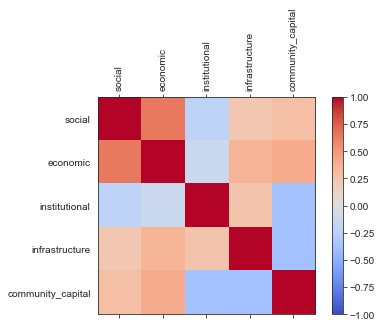

In [8]:
def plot_correlations(df):
    corr = df.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(df.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.columns)
    plt.show()
    
plot_correlations(df_na[subcomponents])

We note that the `economic` and `social` indicators are most positively correlated while the `community capital` and  `institutional` or `infrastructure` indicators are most negatively correlated. 

Let's visualize any correlations between the subcomponent/subindex variables:

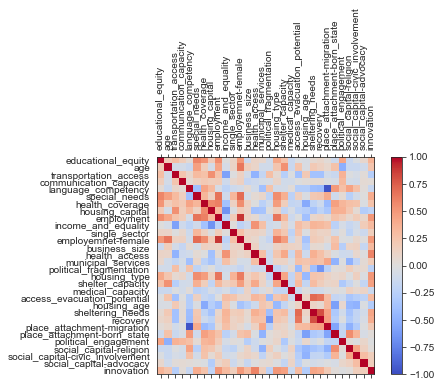

In [9]:
plot_correlations(df_na[sub_vars])

Here, we note that the `employment-female` and `employment` variables are most positively correlated while the `place_attachement-migration` and `language_competency` variables are most negatively correlated.

Remember that we filtered all counties where there were NaN values in any of the subindex variables. Let's visualize the correlation plots for all counties whether or not they contained NaN values:

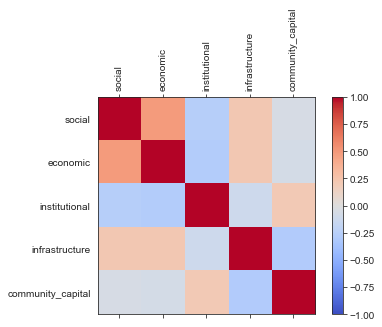

In [10]:
plot_correlations(df[subcomponents])

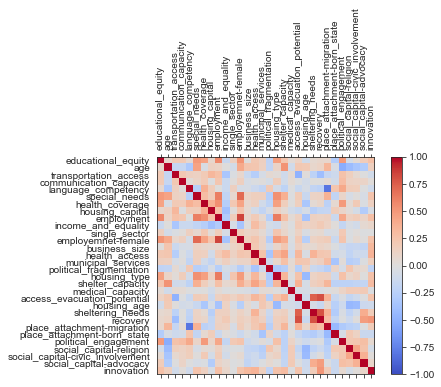

In [11]:
plot_correlations(df[sub_vars])

We note that that the `recovery` and `sheltering_needs` variables are highly correlated with the `access_evacuation_potential` variable.

Let's generate a heirarchically-clustered heatmap to verify these correlations:

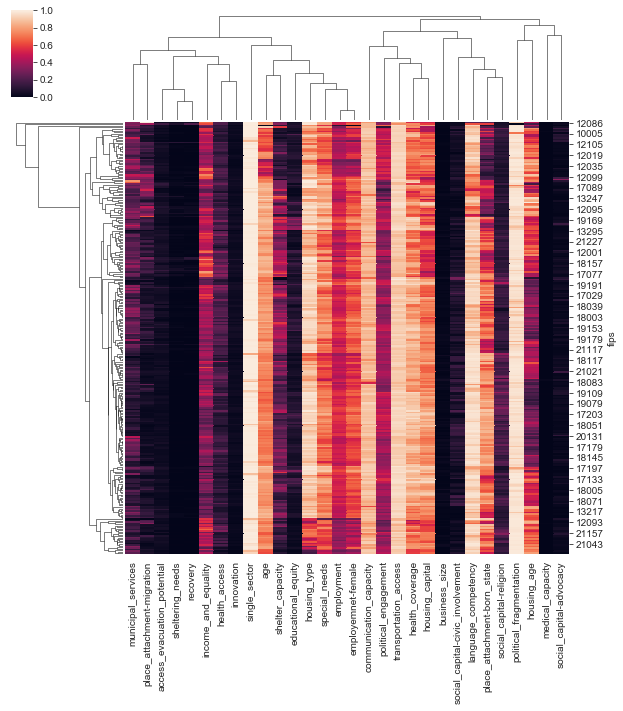

In [12]:
g = sns.clustermap(df_na[sub_vars], metric='correlation')

We note that `employment` and `employment-female` are once again highly correlated positively while `recovery` and `sheltering_needs` are highly correlated inversely.

Finally, we generate a cluster heatmap using the euclidean metric to visualize the clusters:

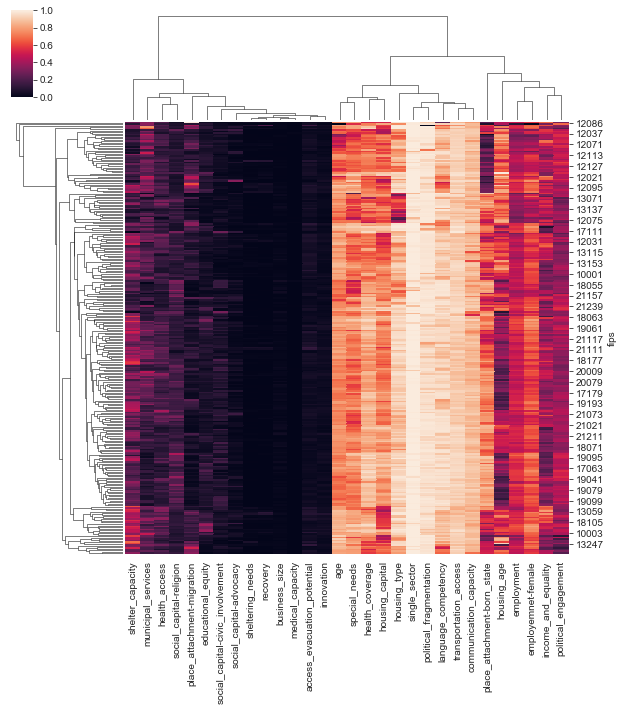

In [13]:
g = sns.clustermap(df_na[sub_vars])

Looking at the cluster heatmaps for the correlation between the resilience indicators:

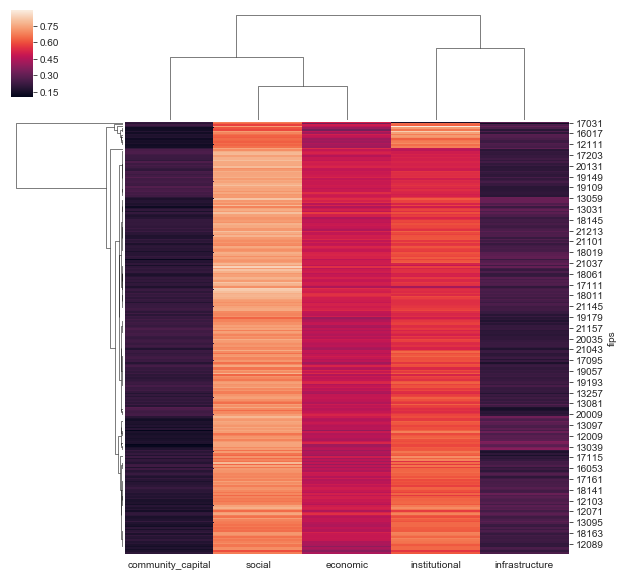

In [14]:
g = sns.clustermap(df_na[subcomponents], metric='correlation')

We verify that `social` and `economic` indicators are positively correlated.

Looking at the cluster heatmaps between the resilience indicators using the `euclidean` metric:

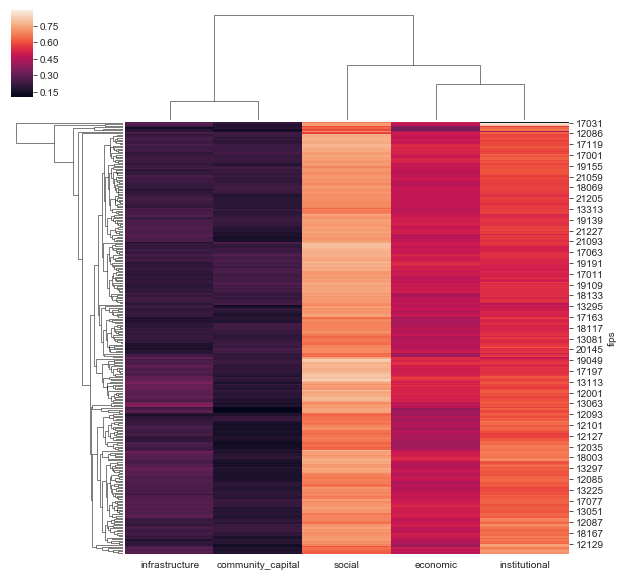

In [15]:
g = sns.clustermap(df_na[subcomponents])